In [4]:
import h5py
import cv2
import warp_norm
import matplotlib
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import gaze_network
from torchvision import transforms
import utils
import pickle
import pandas as pd

with open('./gaze_pred.pkl', 'rb') as fo:
    tinydict = pickle.load(fo, encoding='bytes')

In [28]:
file_names = tinydict['file_name']
file_dict = []
for file_name in file_names:
    file_name = str(file_name).strip('()').split(',')
    for file in file_name:
        file_dict.append(int(file.strip("''").split('/')[6].split('.')[0][19:]))
        # print(file.strip("''").split('/')[6].split('.')[0][19:])
print(file_dict)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 22

In [37]:
with open('/home/hgh/hghData/Datasets/dataset_dict.pkl', 'rb') as fo:
    tinydict2 = pickle.load(fo, encoding='bytes')

In [42]:
ground_truth = [[],[],[],[],[],[],[],[]]
pred = [[],[],[],[],[],[],[],[]]
RMat = [[],[],[],[],[],[],[],[]]
for i in range(len(file_dict)):
    number = int((file_dict[i] - 1)/100)
    ground_truth[number].append(tinydict['label'][i])
    pred[number].append(tinydict['pred_gaze'][i])
    RMat[number].append(tinydict2[i]['R'])
for i in range(len(ground_truth)):
    ground_truth[i] = np.vstack(ground_truth[i])
    pred[i] = np.vstack(pred[i])
print(RMat[0][0])

[[ 0.99934383 -0.03606395  0.00336276]
 [ 0.03610734  0.99925146 -0.01388445]
 [-0.00285951  0.01399676  0.99989795]]


In [63]:
# 将pitchyaw转换成vector
for i in range(len(ground_truth)):
    pred[i] = warp_norm.pitchyaw_to_vector(pred[i])

print(pred[0][0])

# 将归一化向量还原
org_pred = [[],[],[],[],[],[],[],[]]
for i in range(len(ground_truth)):
    for j in range(len(RMat[i])):
        org_pred[i].append(np.dot(np.linalg.inv(RMat[i][j]), pred[i][j].T))
print(org_pred[0][0])

[-0.15904158 -0.14015099  0.97727349]
[[ 0.99934383 -0.03606395  0.00336276]
 [ 0.03610734  0.99925146 -0.01388445]
 [-0.00285951  0.01399676  0.99989795]]
[-0.16679223 -0.12063175  0.97858486]


In [ ]:
pixel_scale_tan = 0.211667
pixel_scale_chen = 0.223427

pred_gc = [[],[],[],[],[],[],[],[]]
for i in range(len(ground_truth)):
    for j in range(len(pred)):
        if i%2 == 0:
            pred_gc.append(warp_norm.vector_to_gc(pred[i], pixel_scale))

In [8]:
ground_truth = [[],[],[],[],[],[],[],[]]
for data in loaded_dataset_dict:
    # print(f"Sample {key}: {value}")
    # 取出男生的数据
    print(data)
    image_name = os.path.basename(data['image_path'])
    # print(image_name)
    number = int((int(os.path.splitext(image_name)[0][19:]) - 1)/100)
    ground_truth[number].append(data['label'].reshape((1,3))[0])
for i in range(len(ground_truth)):
    ground_truth[i] = np.vstack(ground_truth[i])
    ground_truth[i] = warp_norm.vector_to_pitchyaw(ground_truth[i])
# print(len(ground_truth[2]))
pred = []
pred_path = './results.txt'

with open(pred_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    data_array = [float(x) for x in line.split()]
    pred.append(data_array)
pred = np.array(pred)

idx = 0
idy = 0
tan_pred = []
for gt_block in ground_truth:
    print(len(gt_block))
    if idy % 2 == 0:
       tan_pred.append(pred[idx:idx+len(gt_block)])
    err = utils.angular_error(gt_block, pred[idx:idx+len(gt_block)])
    idx = idx+len(gt_block)
    print('error:', np.mean(err))

tan_pred = np.vstack(tan_pred)
tan_pred = warp_norm.pitchyaw_to_vector(tan_pred)
tan_pred_gc = []
for i in range(len(tan_pred)):
    tan_pred_gc.append(warp_norm.vector_to_gc(tan_pred[i],1920,1080,0.211667))
tan_pred_gc = np.vstack(tan_pred_gc)
print(tan_pred_gc)

('/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_1.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_2.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_3.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_4.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_5.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_6.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_7.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_8.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_9.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_10.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_11.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_12.jpg', '/home/hgh/hghData/Datasets/preprocessed_images/preprocessed_image_13.jpg', '/home/hgh/hghData/D

NameError: name 'loaded_dataset_dict' is not defined

In [3]:
data = pd.read_csv('/home/hgh/hghData/Datasets/preprocessed_labels.csv')
image_path = data.loc[:, 'image_path']
label = data.loc[:, 'label']
results = np.loadtxt('./results.txt')

In [4]:
img = cv2.imread(image_path[1])
print(label[11])
cleaned_string = label[11].replace('\n', '').replace(' ', '')
# 将字符串切分成单个数字的列表
numbers = cleaned_string.split('][')
numbers[0] = numbers[0].lstrip('[')
numbers[-1] = numbers[-1].rstrip(']')
# 将字符串转换为浮点数，并重新组成 NumPy 数组
numpy_array = np.array([float(num) for num in numbers]).reshape(3,1)
gaze_img = warp_norm.draw_gaze(img, numpy_array, color = (0,255,0))
gaze_img = warp_norm.draw_gaze(img, results[1])
plt.imshow(cv2.cvtColor(gaze_img, cv2.COLOR_BGR2RGB))
plt.show()

[[-0.28187772]
 [-0.04848431]
 [ 0.95822452]]


[ WARN:0@4.095] global loadsave.cpp:248 findDecoder imread_('preprocessed_image_2.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [5]:
import os
import pandas as pd
import numpy as np
import pickle

csv_file_path = '/home/hgh/hghData/Datasets/preprocessed_labels.csv'
df = pd.read_csv(csv_file_path)
dataset_dict = {}

for index, row in df.iterrows():
    image_path = row['image_path']
    label = row['label']
    cleaned_string = label.replace('\n', '').replace(' ', '')
    # 将字符串切分成单个数字的列表
    numbers = cleaned_string.split('][')
    numbers[0] = numbers[0].lstrip('[')
    numbers[-1] = numbers[-1].rstrip(']')  
    # 组织样本信息为字典
    label_array = np.array([float(num) for num in numbers]).reshape(3,1)
    sample_info = {
        'image_path': image_path,
        'label': label_array
    }

    # 将样本信息加入数据集字典，以索引作为键
    dataset_dict[index] = sample_info

# for key, value in dataset_dict.items():
#     print(f"Sample {key}: {value}")

pickle_file_path = '/home/hgh/hghData/Datasets/dataset_dict.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(dataset_dict, file)


In [11]:
import warp_norm
import numpy as np
gv = np.array([0.0685,0.3065,-0.94944])
if gv.size == 2:
    gv = warp_norm.pitchyaw_to_vector(gv)
z = np.array([0,0,-600])
theta = np.arcsin(np.linalg.norm(np.cross(gv,z))/(np.linalg.norm(gv)*np.linalg.norm(z)))
print(theta)
scale = np.linalg.norm(z)/(np.cos(theta)*np.linalg.norm(gv))
print(scale)
gp = scale * gv - z
print(gp)
gp = np.delete(gp, 2, axis=0)
t = np.array([0.215,0.215])
s = np.array([500,500])
print(gp/t+s)

0.31945605309159664
631.9514661274015
[ 4.32886754e+01  1.93693124e+02 -1.13686838e-13]
[ 701.34267642 1400.89825287]


# 计算总体误差

In [12]:
import os
import pandas as pd
import numpy as np
import pickle
import warp_norm
import utils

pickle_file_path = '/home/hgh/hghData/Datasets/dataset_dict.pkl'
with open(pickle_file_path, 'rb') as file:
    loaded_dataset_dict = pickle.load(file)
ground_truth = []
idx = 0
tan_list = []
for data in loaded_dataset_dict:
    # print(f"Sample {key}: {value}")
    # 取出男生的数据
    image_name = os.path.basename(data['image_path'])
    # print(image_name)
    number = int((int(os.path.splitext(image_name)[0][19:]) - 1)/100)
    if number % 2 == 0:
        tan_list.append(idx)
    ground_truth.append(data['label'].reshape((1,3))[0])
    idx+=1
ground_truth = np.array(ground_truth)
print(tan_list)
ground_truth = warp_norm.vector_to_pitchyaw(ground_truth)
print(ground_truth)

pred = []
pred_path = './results.txt'

with open(pred_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    data_array = [float(x) for x in line.split()]
    pred.append(data_array)
pred = np.array(pred)
print(pred)

ground_truth_tan = ground_truth[tan_list]
pred_tan = pred[tan_list]

mask = np.isin(np.arange(len(ground_truth)), tan_list, invert=True)
ground_truth_chen = ground_truth[mask]
pred_chen = pred[mask]


e_tan = utils.angular_error(ground_truth_tan,pred_tan)
print('Tan error:', np.mean(e_tan))


e_chen = utils.angular_error(ground_truth_chen,pred_chen)
print('Chen error:', np.mean(e_chen))

e = utils.angular_error(ground_truth,pred)
print('Total error:', np.mean(e))



TypeError: 'int' object is not subscriptable

# 分块误差计算

In [16]:
import os
import pandas as pd
import numpy as np
import pickle
import warp_norm
import utils

pickle_file_path = '/home/hgh/hghData/Datasets/dataset_dict.pkl'
with open(pickle_file_path, 'rb') as file:
    loaded_dataset_dict = pickle.load(file)

ground_truth = [[],[],[],[],[],[],[],[]]
for data in loaded_dataset_dict:
    # print(f"Sample {key}: {value}")
    # 取出男生的数据
    print(data)
    image_name = os.path.basename(data['image_path'])
    # print(image_name)
    number = int((int(os.path.splitext(image_name)[0][19:]) - 1)/100)
    ground_truth[number].append(data['label'].reshape((1,3))[0])
for i in range(len(ground_truth)):
    ground_truth[i] = np.vstack(ground_truth[i])
    ground_truth[i] = warp_norm.vector_to_pitchyaw(ground_truth[i])
# print(len(ground_truth[2]))
pred = []
pred_path = './results.txt'

with open(pred_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    data_array = [float(x) for x in line.split()]
    pred.append(data_array)
pred = np.array(pred)

idx = 0
idy = 0
tan_pred = []
for gt_block in ground_truth:
    print(len(gt_block))
    if idy % 2 == 0:
       tan_pred.append(pred[idx:idx+len(gt_block)])
    err = utils.angular_error(gt_block, pred[idx:idx+len(gt_block)])
    idx = idx+len(gt_block)
    print('error:', np.mean(err))

tan_pred = np.vstack(tan_pred)
tan_pred = warp_norm.pitchyaw_to_vector(tan_pred)
tan_pred_gc = []
for i in range(len(tan_pred)):
    tan_pred_gc.append(warp_norm.vector_to_gc(tan_pred[i],1920,1080,0.211667))
tan_pred_gc = np.vstack(tan_pred_gc)
print(tan_pred_gc)


0


TypeError: 'int' object is not subscriptable

# 判断屏幕点的情况
- 原数据是否均匀
- 注视（测试数据/预测数据）（归一化/未归一化）是否均匀

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle
import warp_norm
import utils

# 判断原数据归一化后的均匀性
# print(ground_truth[0])
tan_list = []
chen_list = []
for i in range(len(ground_truth)):
    if i % 2 == 0:
        tan_list.append(ground_truth[i])
    else:
        chen_list.append(ground_truth[i])
tan_list = np.vstack(tan_list)
chen_list = np.vstack(chen_list)
# print(len(chen_list))
tan_list = warp_norm.pitchyaw_to_vector(tan_list)
tan_gz = []
for i in range(len(tan_list)):
    tan_gz.append(warp_norm.vector_to_gc(tan_list[i], 1920, 1080, 0.211667))
tan_gz = np.vstack(tan_gz)

0.374248170997297
644.6187478452529
0.2657587212904193
621.8302803978534
0.1934720265118291
611.407273528476
0.28245120138738167
624.7558581372434
0.30683230987127535
629.395857015653
0.225845143407637
615.6338984383497
0.39575907576330266
650.2625652509023
0.0861993981277689
602.2360230246261
0.3519531805352103
639.1810436544733
0.3418259071258653
636.8452027782195
0.08366585701734722
602.1061351317637
0.2900676961630166
626.1580562036968
0.2196776332788927
614.7744132601181
0.11370523025623684
603.8996687433546
0.13089848182414482
605.1772797787289
0.39015532049129614
648.7538536246842
0.320607016037959
632.2149581017335
0.3018402641867299
628.4097535995697
0.0902935549758975
602.4542142357956
0.2552150702629874
620.0851644082152
0.041251616158919535
600.5108709724717
0.30410231465467563
628.8542628493913
0.30679975058900627
629.3893645510173
0.24598400734341683
618.6216383637233
0.12389095901130558
604.6343247447148
0.21072343022893064
613.5723099254507
0.20543183718047578
612.88718

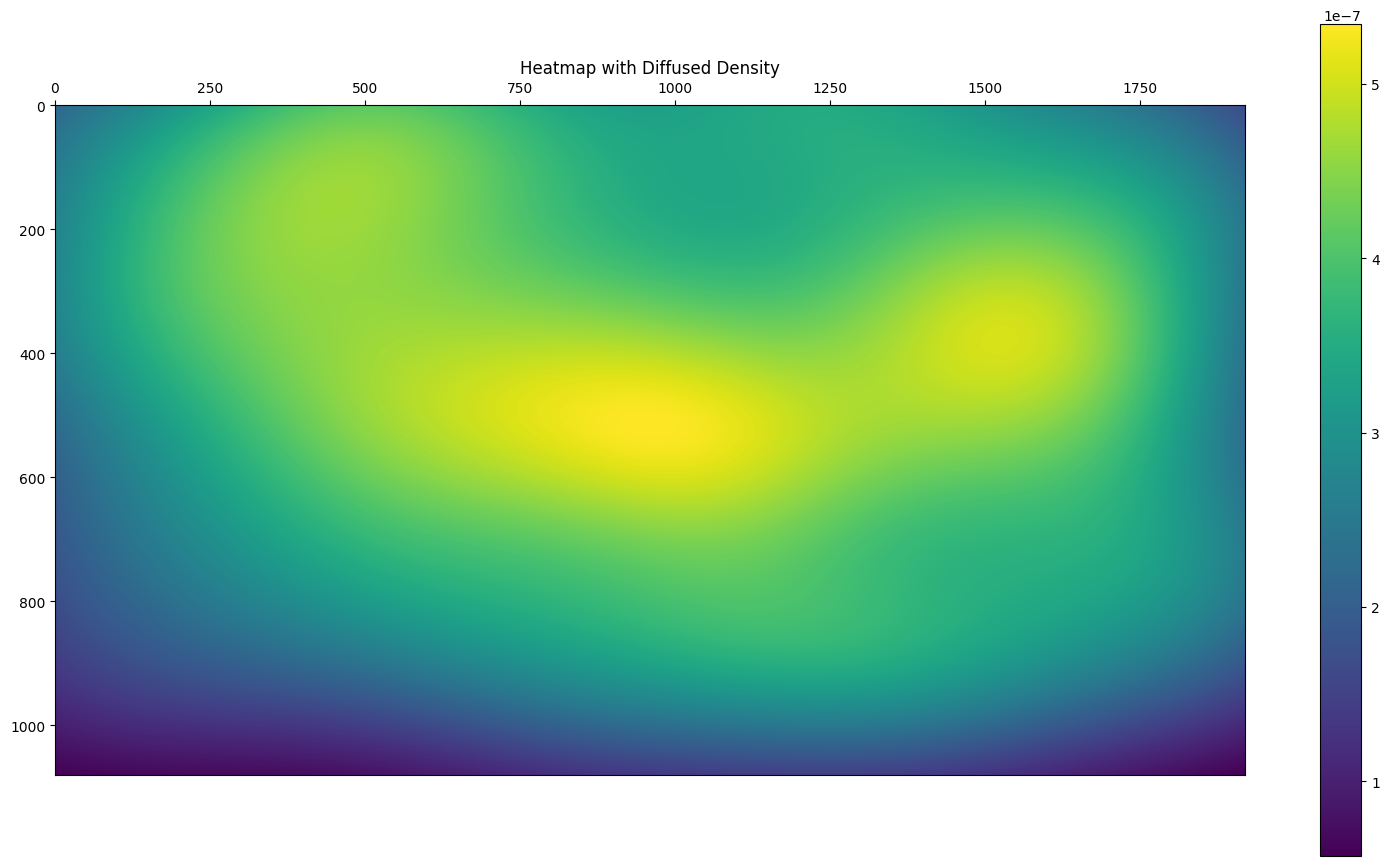

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x = tan_gz[:, 0]
y = tan_gz[:, 1]
data = np.column_stack((tan_gz[:, 0], tan_gz[:, 1]))

# 计算核密度估计
kde = gaussian_kde(data.T)

# 生成网格
x, y = np.mgrid[0:1920:1920j, 0:1080:1080j]


# 计算核密度估计值在网格上的值
positions = np.vstack([x.ravel(), y.ravel()])
z = np.reshape(kde(positions).T, x.shape)

# 设置画布大小
plt.figure(figsize=(1920 / 100, 1080 / 100), dpi=100)

# 绘制热力图
plt.imshow(z, cmap='viridis',extent=[0, 1920, 0, 1080], origin='lower')
plt.colorbar()  # 显示颜色条
plt.title('Heatmap with Diffused Density')
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.show()

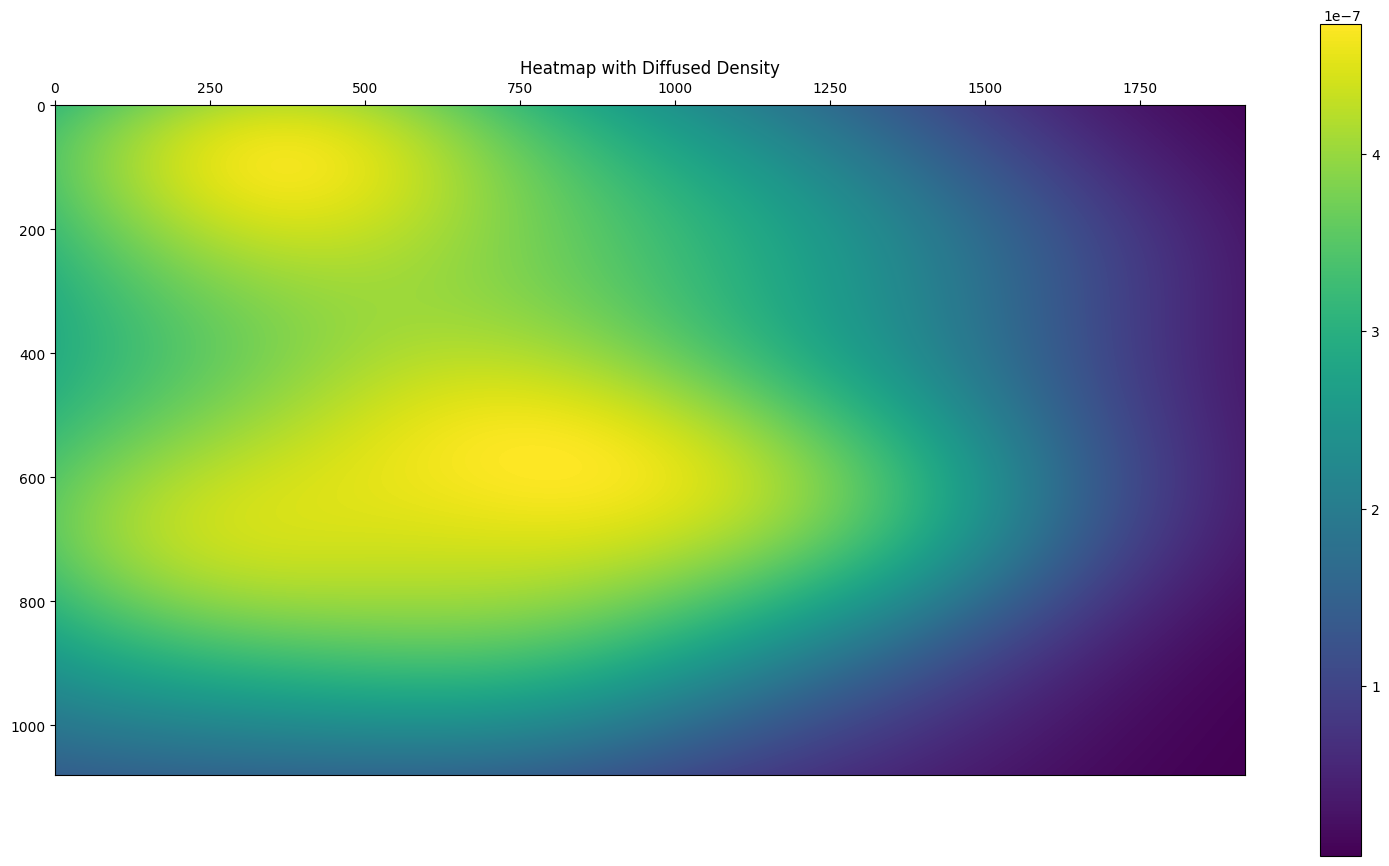

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


data = np.column_stack((tan_pred_gc[:, 0], tan_pred_gc[:, 1]))

# 计算核密度估计
kde = gaussian_kde(data.T)

# 生成网格
x, y = np.mgrid[0:1920:1920j, 0:1080:1080j]


# 计算核密度估计值在网格上的值
positions = np.vstack([x.ravel(), y.ravel()])
z = np.reshape(kde(positions).T, x.shape)

# 设置画布大小
plt.figure(figsize=(1920 / 100, 1080 / 100), dpi=100)

# 绘制热力图
plt.imshow(z, cmap='viridis',extent=[0, 1920, 0, 1080], origin='lower')
plt.colorbar()  # 显示颜色条
plt.title('Heatmap with Diffused Density')
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.show()